In [1]:
#import necessary library & settings
import torch
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import warnings
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
#HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00 ", "#FF006D", "#ADFF02", "#8F00FF"]
#sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
warnings.filterwarnings('ignore')

cuda:0


## Load English Data

In [12]:
import pandas as pd
# Read train data
df = pd.read_csv('C:/Users/Yuheng/sst_train.txt', sep='\t', header=None, names=['truth', 'text'],encoding='latin-1')
df = df[:8000]
df['truth'] = df['truth'].str.replace('__label__', '')
df['truth'] = df['truth'].astype(int).astype('category')



## Rearrange sentiment into 3 sentiments

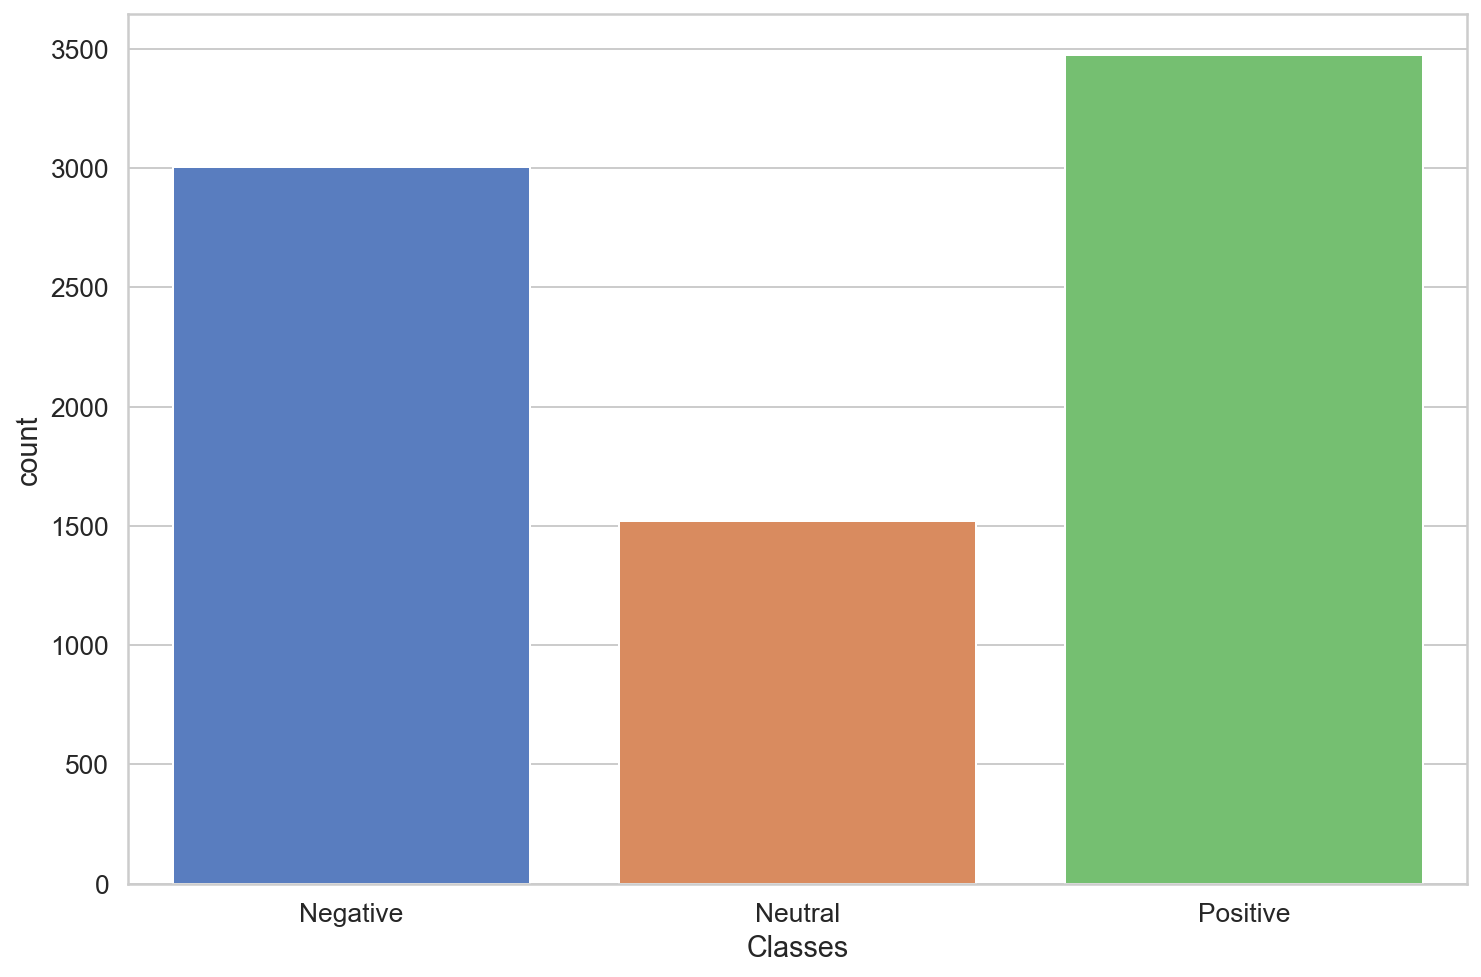

In [13]:
def to_sentiment(rating):
  rating = int(rating)
  if rating == 1:
    return 0
  elif rating == 2:
    return 0
  elif rating == 3:
    return 1
  elif rating == 4:
    return 2
  else:
    return 2
df['truth'] = df.truth.apply(to_sentiment)
class_names = ['Negative','Neutral','Positive']
ax = sns.countplot(df.truth)
plt.xlabel('Classes')
ax.set_xticklabels(class_names);


In [14]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-uncased'

In [15]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [16]:
class_names = ['Negative','Neutral', 'Positive']
#model = SentimentClassifier(len(class_names))
model = bert_model.to(device)

## Get sentence embeddings for English data

In [17]:
#extract CLS token for every sentence
encoded=[]
for i in range (0,len(df['text'])):
    encoded_review = tokenizer.encode_plus(
      df['text'][i],
      max_length=512,
      truncation=True,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    feature = last_hidden_states
    features = (feature[0][:,0,:].cpu()).numpy().flatten() #extract the last CLS token from BERT-layer and flatten into 1d array
    encoded.append(features)

    

In [18]:
labels=df['truth']

In [19]:
train_features, test_features, train_labels, test_labels = train_test_split(encoded, labels, random_state=42)

## English Classifier

#### English Classifier SE-768

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import time
svc_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
start_time = time.time()
svc_clf.fit(train_features,train_labels)
svc_score=svc_clf.score(test_features, test_labels)
print(svc_score)
print("--- %s seconds ---" % (time.time() - start_time))

0.616
--- 19.48104500770569 seconds ---


#### English Classifier SE PCA-200

In [36]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import time

svc_en_clf_pca = make_pipeline(StandardScaler(), SVC(gamma='auto'))
start_time = time.time()
pca_en = PCA(n_components=200)
x_en_pca = pca_en.fit_transform(encoded)
train_features_en_pca, test_features_en_pca, train_labels_en_pca, test_labels_en_pca = train_test_split(x_en_pca, labels, random_state=42)
svc_en_clf_pca.fit(train_features_en_pca, train_labels_en_pca)
svc_score=svc_en_clf_pca.score(test_features_en_pca, test_labels_en_pca)
print(svc_score)
print("--- %s seconds ---" % (time.time() - start_time))

0.6265
--- 4.694056272506714 seconds ---


## Load Malay Data

In [22]:
df_malay = pd.read_csv('Desktop/sst-5_malay.csv', header=0, names=['sentence', 'label'],encoding='latin-1')
df_malay = df_malay[:8000]

In [23]:
df_malay['label']=df_malay.label.apply(to_sentiment)
df_malay.tail()

,sentence,label
7995,Sketsa Sha-Na-Na diselingi dengan kekerasan gr...,1
7996,"Masalahnya ialah, pembuat filemnya kehabisan i...",0
7997,Perisik-vs.,1
7998,- aksi perisik dengan Antonio Banderas dan Luc...,0
7999,Sesuatu yang begitu biasa dibuat untuk TV yang...,0


## Get sentence embeddings for Malay data

In [24]:
encoded_malay=[]
for i in range (0,len(df_malay['sentence'])):
    encoded_review = tokenizer.encode_plus(
      df_malay['sentence'][i],
      max_length=512,
      truncation=True,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    feature = last_hidden_states
    features = (feature[0][:,0,:].cpu()).numpy().flatten() #extract the last CLS token from BERT-layer and flatten into 1d array
    encoded_malay.append(features)

In [25]:
labels_malay=df_malay['label']

## Concatenate English and Malay data

In [26]:
encoded_mix=np.concatenate((encoded,encoded_malay), axis=0)


In [27]:
labels_mix=np.concatenate((labels,labels_malay), axis=0)

In [28]:
train_features_mix, test_features_mix, train_labels_mix, test_labels_mix = train_test_split(encoded_mix, labels_mix, random_state=42)


## Result - SE-768 Single Classifier

In [30]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import time
svc_mix_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
start_time = time.time()
svc_mix_clf.fit(train_features_mix,train_labels_mix)
svc_mix_score=svc_mix_clf.score(test_features_mix, test_labels_mix)
print(svc_mix_score)
print("--- %s seconds ---" % (time.time() - start_time))

0.61225
--- 81.24133610725403 seconds ---


## Malay dataset splitting

In [31]:
train_features_new_malay, test_features_new_malay, train_labels_new_malay, test_labels_new_malay = train_test_split(encoded_malay, labels_malay, random_state=42)

## Train Malay Classifier

#### Malay Classifier SE-768

In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import time
start_time = time.time()
svc_malay_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svc_malay_clf.fit(train_features_new_malay,train_labels_new_malay)
svc_malay_score=svc_malay_clf.score(test_features_new_malay, test_labels_new_malay)
print(svc_malay_score)
print("--- %s seconds ---" % (time.time() - start_time))

0.5755
--- 19.975905895233154 seconds ---


#### Malay Classifier with SE PCA-200

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import time
start_time = time.time()
pca_malay = PCA(n_components=200)
x_malay_pca = pca_malay.fit_transform(encoded_malay)
train_features_malay_pca, test_features_malay_pca, train_labels_malay_pca, test_labels_malay_pca = train_test_split(x_malay_pca, labels_malay, random_state=42)
svc_malay_clf_pca = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svc_malay_clf_pca.fit(train_features_malay_pca,train_labels_malay_pca)
svc_malay_pca_score=svc_malay_clf_pca.score(test_features_malay_pca, test_labels_malay_pca)
print(svc_malay_pca_score)
print("--- %s seconds ---" % (time.time() - start_time))

0.5865
--- 4.841115236282349 seconds ---


In [38]:
import requests
def langdetect(text):
    src='auto'##english, can chg to \"auto\" for language detection
    dest='ms' #malay
    url = "https://clients5.google.com/translate_a/t?client=dict-chrome-ex&sl="+src+"&tl="+dest+"&q=" + text
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.104 Safari/537.36'}
    try:
        request_result = requests.get(url, headers=headers).json()     
        #print(request_result)
        #print('-------')
        #print('[In Malay]: ' + request_result['alternative_translations'][0]['alternative'][0]['word_postproc'])
        #result=request_result['alternative_translations'][0]['alternative'][0]['word_postproc'] #get translated result
        result=request_result['src'] ## get the detected language
        #print('[Language Dectected]: ' + request_result['src'])
    except:
        pass
    return result

## Load testing data (2000+2000)

In [39]:
df_test_new = pd.read_csv('Desktop/test_mix.csv')
df_test_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     4000 non-null   int64 
 1   sentence  4000 non-null   object
 2   lan       4000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 93.9+ KB


## Result - Combined SE-768 Feature

In [40]:
#extract CLS token for every sentence
match=0
false=0
false_lan=0
match_lan=0
i=0
start_time = time.time()
for i in range (0,len(df_test_new['sentence'])):
    encoded_review = tokenizer.encode_plus(
      df_test_new['sentence'][i],
      max_length=512,
      truncation=True,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    feature = last_hidden_states
    features = (feature[0][:,0,:].cpu()).numpy() #extract the last CLS token from BERT-layer
    #prediction_language=int(svc_lan_clf.predict(features))
    #print('Label:',prediction)
    #print(f'Sentiment  : {class_names[prediction]}')
    lan=langdetect(df_test_new['sentence'][i])
    #print(lan)
    if(lan=='en'):
        prediction_language=0
    elif(lan=='ms'):
        prediction_language=1
    else:
        prediction_language=1
    if (df_test_new['lan'][i]==prediction_language):
        match_lan+=1
        if(prediction_language==0):#en
            prediction=int(svc_clf.predict(features))
            if (df_test_new['label'][i]==prediction): 
                match+=1
            elif(df_test_new['label'][i]!=prediction):
                false+=1
        elif(prediction_language==1): #malay
            prediction=int(svc_malay_clf.predict(features))
            if (df_test_new['label'][i]==prediction): 
                match+=1
            elif(df_test_new['label'][i]!=prediction):
                false+=1
    elif(df_test_new['lan'][i]!=prediction_language):
        false_lan+=1
            

accuracy_sentiment=((match)/len(df_test_new['sentence']))*100
print('Accuracy of Sentiment:',"{:.2f}".format(round(accuracy_sentiment, 2)),'%')


accuracy_language=(match_lan/len(df_test_new['sentence']))*100
print('Accuracy of Language:',"{:.2f}".format(round(accuracy_language, 2)),'%')
print("--- %s seconds ---" % (time.time() - start_time))

Accuracy of Sentiment: 59.50 %
Accuracy of Language: 99.78 %
--- 356.4530279636383 seconds ---


## Result - Combined With PCA-200

In [41]:
#extract CLS token for every sentence
match=0
match_en=0
match_malay=0
false=0
false_en=0
false_malay=0
false_lan=0
match_lan=0

i=0
start_time = time.time()
for i in range (0,len(df_test_new['sentence'])):
    encoded_review = tokenizer.encode_plus(
      df_test_new['sentence'][i],
      max_length=512,
      truncation=True,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    feature = last_hidden_states
    features = (feature[0][:,0,:].cpu()).numpy() #extract the last CLS token from BERT-layer
    #prediction_language=int(svc_lan_clf.predict(features))
    #print('Label:',prediction)
    #print(f'Sentiment  : {class_names[prediction]}')
    lan=langdetect(df_test_new['sentence'][i])
    #print(lan)
    if(lan=='en'):
        prediction_language=0
    elif(lan=='ms'):
        prediction_language=1
    else:
        prediction_language=1
    if (df_test_new['lan'][i]==prediction_language):
        match_lan+=1
        if(prediction_language==0):#en
            prediction=int(svc_en_clf_pca.predict(pca_en.transform(features)))
            if (df_test_new['label'][i]==prediction): 
                match+=1
                match_en+=1
            elif(df_test_new['label'][i]!=prediction):
                false+=1
                false_en+=1
        elif(prediction_language==1): #malay
            prediction=int(svc_malay_clf_pca.predict(pca_malay.transform(features)))
            if (df_test_new['label'][i]==prediction): 
                match+=1
                match_malay+=1
            elif(df_test_new['label'][i]!=prediction):
                false+=1
                false_malay+=1
    elif(df_test_new['lan'][i]!=prediction_language):
        false_lan+=1
            
print('English misclassification:', false_en)
print('Malay misclassification:', false_malay)
accuracy_sentiment=((match)/len(df_test_new['sentence']))*100
print('Accuracy of Sentiment:',"{:.2f}".format(round(accuracy_sentiment, 2)),'%')


accuracy_language=(match_lan/len(df_test_new['sentence']))*100
print('Accuracy of Language:',"{:.2f}".format(round(accuracy_language, 2)),'%')
print("--- %s seconds ---" % (time.time() - start_time))

English misclassification: 749
Malay misclassification: 823
Accuracy of Sentiment: 60.48 %
Accuracy of Language: 99.78 %
--- 346.1640431880951 seconds ---
